# scRNASeq pipeline analysis using scanpy
This scRNA-Seq pipeline is adapted from the pipeline here https://github.com/theislab/single-cell-tutorial. Focusing more on technical details of each step. <br/>

## Prepare pipeline environment
To run this pipline, we recommend to use the docker contianer (https://hub.docker.com/r/leanderd/single-cell-analysis) built by the scanpy developer. That page describes how to run the pipeline using docker. If you are using HPC, then it's recommended to run this pipeline using singularity. You can download the docker image using singularity with the command: <br/> 
> **singularity pull docker://leanderd/single-cell-analysis**. <br/>

Another docker container that has both scanpy and seurat is: <br/>
> **singularity pull docker://shl198/sc_ppl:202306**. <br/>

Singularity image file is not writable, you can transfer it to a sandbox and then you will be able to install packages inside it without administrator role. The commands are:
> singularity build --sandbox sc_pipeline/ single-cell-analysis.sif <br/>
> singularity run -w sc_pipeline jupyter-lab --no-browser --port 8887

In the end, you can open jupyter-lab by copying and pasting the url shown in terminal.

# 0. Load the packages

In [ ]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

import glob
import os
import anndata
plt.style.use('ggplot')

import scanpy_utils.scanpy_utils as sctool

In [ ]:
# if you changed codes in scanpy_utils.py, you need to run this chunk to update the loading
import importlib
import scanpy_utils.scanpy_utils as sctool
importlib.reload(sctool)

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
anndata2ri.scipy2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.0
-----
PIL                         9.2.0
anndata2ri                  1.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi                        1.15.0
chardet                     4.0.0
charset_normalizer          2.0.8
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dask                        2021.11.2
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints                 0.3
fasteners                   NA
fsspec                      2022.8.2
google                      NA
gprofiler    

In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

# 1. Read in the data
For 10X genomics data, it has 3 files for each sample, 10X genomics has two version of files. </br>

For version 2, please make sure the files are unzipped and file names end with **_matrix.mtx, _barcodes.tsv.gz, _genes.tsv**. </br>
For version 3, please make sure the files are gzipped and file names end with **_matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz**. <br/>

There two ways of putting files in the folder and you need to define a parameter called **file_tree**: <br/>
1. Put all the files from different samples in the same folder, in this case just make sure the files end with the ones mentioned above.
2. Each sample's files are put in a spearate folder, in this case you need to make sure the file names are exactly **matrix.mtx, barcodes.tsv, genes.tsv** or **matrix.mtx.gz, barcodes.tsv.gz, genes.tsv.gz**

In [6]:
# define parameters
work_dir = '/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/r01_ref_scrna/liver_cirrohtic/'
raw_path = f'{work_dir}/f01_raw'
cc_genes_file = '/media/home/lis262/Code/Scripts/single-cell-tutorial/Macosko_cell_cycle_genes.txt'
version_10x = 2
file_tree = 'in_1_folder' # if all files are in one folder, set file_tree='in_1_folder', if each sample is in a separate folder set file_tree='in_n_folder'
meta_fn = f'{work_dir}/meta.tsv'

In [7]:
# if all files are in one folder, set file_tree='in_1_folder', if each sample is in a separate folder set file_tree='in_n_folder'
if file_tree == 'in_1_folder':
    file_pres = [f[:f.index('barcodes')] for f in sorted(glob.glob(f'{raw_path}/*barcodes*'))]
elif file_tree == 'in_n_folder':
    file_pres = [f+'/' for f in sorted(glob.glob(f'{raw_path}/*')) if os.path.isdir(f)]

## 1.1 Check format of Feature/gene file
Usually for 10X feature/gene file, there are 3 columns "Ensemble_gene_id, gene_name, gene_info", Scanpy requires the feature file having all 3 columns. Many GEO datasets only have one or two columns, so we need to check the feature and gene file to make sure they have 3 columns.

In [8]:
# make sure feature/gene file has 3 columns
sctool.check_gene_file_format(file_pres, version_10x)

## 1.2 Read using scanpy

In [12]:
adata = read_10x_raw_files(file_pres, file_tree)

... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041150_healthy1_cd45+_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041151_healthy1_cd45-A_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041152_healthy1_cd45-B_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041153_healthy2_cd45+_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041154_healthy2_cd45-_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrn

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [133]:
# read data using scanpy
adata_list = []
for pre in file_pres:
    if file_tree == 'in_1_folder':
        adata_tmp = sc.read_10x_mtx(os.path.dirname(pre),prefix=os.path.basename(pre), cache=True)
    elif file_tree == 'in_n_folder':
        adata_tmp = sc.read_10x_mtx(pre)
    adata_tmp.var_names_make_unique()
    adata_tmp.obs.index = adata_tmp.obs.index.map(lambda x: x.split('-')[0])
    adata_tmp.obs['sample'] = f'{os.path.basename(pre[:-1])}'
    adata_list.append(adata_tmp)
adata = sc.concat(adata_list)
adata.obs_names_make_unique()
adata.var = adata_tmp.var
del adata_list

... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041150_healthy1_cd45+_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041151_healthy1_cd45-A_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041152_healthy1_cd45-B_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041153_healthy2_cd45+_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrna-liver_cirrohtic-f01_raw-GSM4041154_healthy2_cd45-_matrix.h5ad
... reading from cache file cache/media-hpc-grid-wip_drm_targetsciences-projects-p051_senescence_esf-r01_ref_scrn

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [13]:
print(adata.obs['sample'].value_counts())

GSM4041153_healthy2_cd45+       6571
GSM4041160_healthy5_cd45+       5122
GSM4041158_healthy4_cd45+       4937
GSM4041168_cirrhotic4_cd45+     4819
GSM4041154_healthy2_cd45-       4688
GSM4041165_cirrhotic2_cd45-     3673
GSM4041167_cirrhotic3_cd45-     3602
GSM4041164_cirrhotic2_cd45+     3412
GSM4041159_healthy4_cd45-       3306
GSM4041155_healthy3_cd45+       3295
GSM4041156_healthy3_cd45-A      3230
GSM4041169_cirrhotic5_cd45+     2922
GSM4041161_cirrhotic1_cd45+     2380
GSM4041163_cirrhotic1_cd45-B    2046
GSM4041166_cirrhotic3_cd45+     1985
GSM4041150_healthy1_cd45+       1863
GSM4041162_cirrhotic1_cd45-A    1686
GSM4041157_healthy3_cd45-B      1156
GSM4041151_healthy1_cd45-A      1039
GSM4041152_healthy1_cd45-B       478
Name: sample, dtype: int64


## 1.3 Add meta data
This step is more customizable, so you need to change the code

In [145]:
# add meta
if meta_fn != '':
    meta_df = pd.read_csv(meta_fn, sep='\t', header=0)
    meta_df['gsm'] = meta_df['gsm'].map(lambda x: x.split('_')[0])
    adata.obs['gsm'] = adata.obs['sample'].map(lambda x: x.split('_')[0])
    adata.obs = adata.obs.reset_index().merge(meta_df, how='left', on='gsm').set_index('index')

# 2. Preprocessing
## 2.1 QC
Plot distribution of gene_number, read_count, mitochondria percentage. Use scatter plot and histogram to determine the mininum and maximum n_counts  n_genes, and MT percentage.

In [146]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = np.array(adata.X[:, mt_gene_mask].sum(1)).flatten()/adata.obs['n_counts']
adata = adata[adata.obs['n_counts'] < 6e4]

Sample quality plots of n_counts and mt_frac. Typical plots are: <br/>
* violin plots to show the n_counts, mt_frac, scatter plot 
* scatter plots of n_genes VS n_counts colored by mt_frac
* histogram showing distribution of n_genes and n_counts <br/>

If you want to change figuer size run: **_, ax = plt.subplots(figsize=(8, 8))**, then pass ax as a parameter when plotting in scanpy.


/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


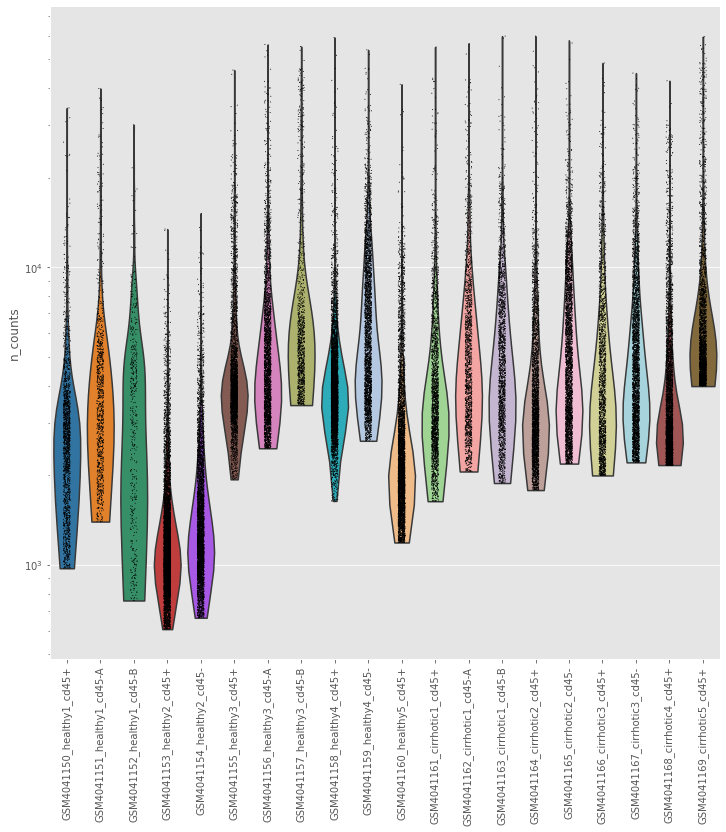

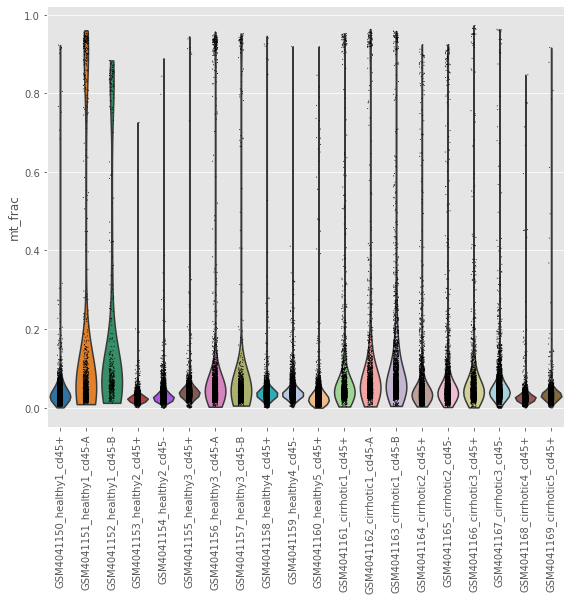

In [15]:
#Sample quality plots
_, ax = plt.subplots(figsize=(12, 12))
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=1, log=True,cut=0,rotation=90, ax=ax)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample',rotation=90)

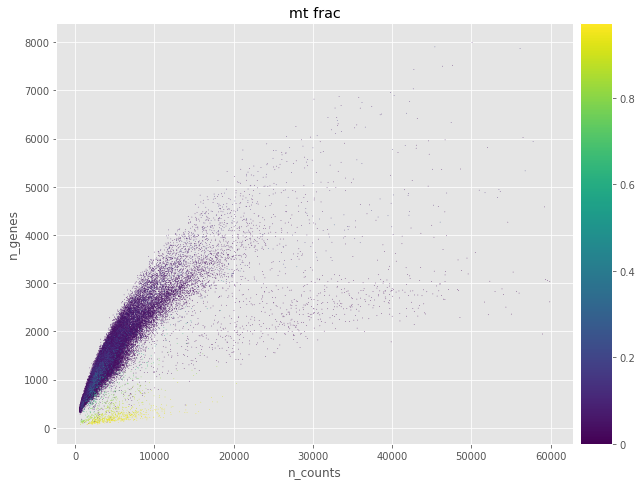

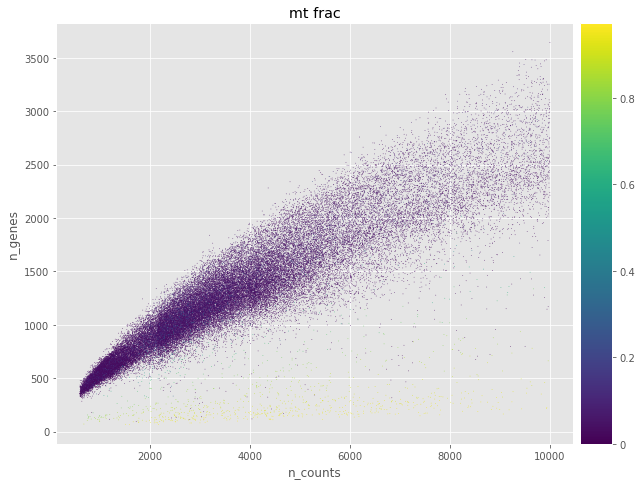

In [16]:
# ncount and ngenes summary, you can change the axis region to zoom in
p1 = sc.pl.scatter(adata,'n_counts','n_genes',color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts'] < 1e4],'n_counts','n_genes',color='mt_frac')

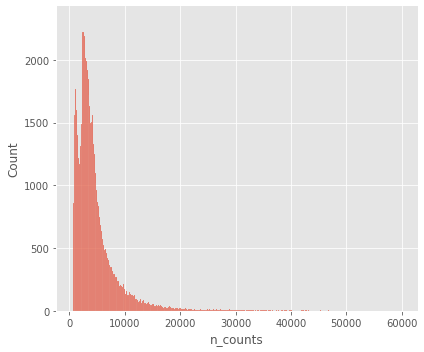

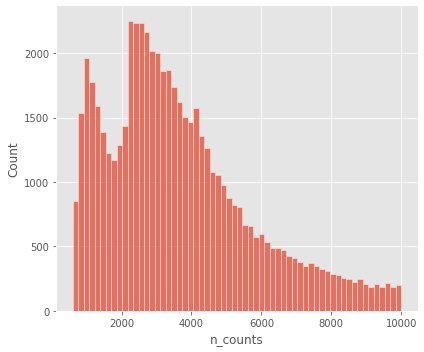

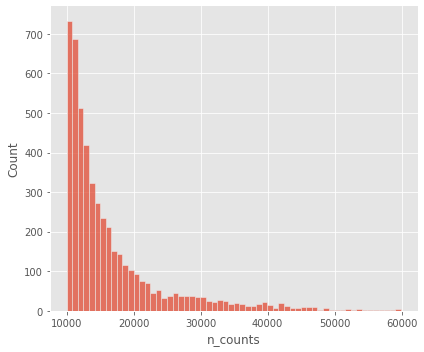

In [17]:
#Thresholding decision: counts, use height and aspect to change figure size
p3 = sb.displot(adata.obs['n_counts'], kde=False,height=5, aspect=1.2)
p4 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts'] < 1e4], kde=False, bins=60,height=5,aspect=1.2)
p5 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts'] > 1e4], kde=False, bins=60,height=5,aspect=1.2)

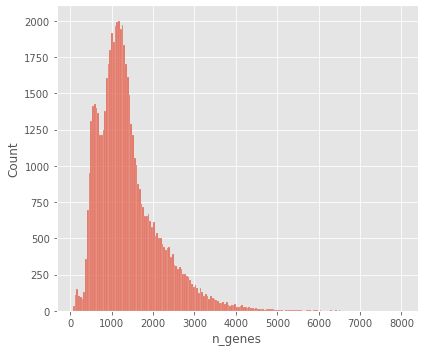

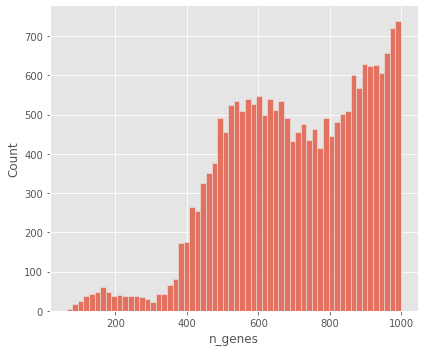

In [18]:
#Thresholding decision: genes
p5 = sb.displot(adata.obs['n_genes'], kde=False,height=5, aspect=1.2)
p6 = sb.displot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60,height=5,aspect=1.2)

From the above QC plots, you can determine the threshold for filtering n_genes, n_counts, mt_fraction

In [147]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 4e4)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.15]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after min gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_genes = 4000)
print('Number of cells after max gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 62195
filtered out 12618 cells that have less than 2000 counts


Trying to set attribute `.obs` of view, copying.


Number of cells after min count filter: 49577
filtered out 135 cells that have more than 40000.0 counts
Number of cells after max count filter: 49442
Number of cells after MT filter: 47457
filtered out 23 cells that have less than 400 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 47434
filtered out 481 cells that have more than 4000 genes expressed
Number of cells after max gene filter: 46953


## 2.2 Normalization
In single cell experiment, different cells may capture different number of molecules, in other words, cells have different depth. So it's better to calculate size factors to reflect the relative number of molecules sequenced in each cell and then normalize based on it. <br/>
Benchmark work [Buettner et al., 2019](https://www.nature.com/articles/s41592-018-0254-1) shows that scran performs the best. But this step takes too much memory and runs for a long time.
This step creates a copy of adata and run clustering to generate a pre-clusters which will be used for scran.

In [148]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e4)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=15
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:08)


In [149]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [150]:
#Delete adata_pp
del adata_pp

Calculating size factors using scrun is memory intensive, and also takes a lot of time, espetially using dense array (if your data has 60k cells, it would take about a little over 70 GB memory). So it's strongly recommended to run using sparse matrix.

In [151]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

... storing 'sample' as categorical
... storing 'gsm' as categorical
... storing 'specimen_from_organism.diseases' as categorical
... storing 'specimen_from_organism.organ' as categorical
... storing 'specimen_from_organism.preservation_storage.preservation_method' as categorical
... storing 'donor_organism.sex' as categorical
... storing 'donor_organism.biomaterial_core.biomaterial_id' as categorical
... storing 'donor_organism.genus_species' as categorical
... storing 'donor_organism.development_stage' as categorical
... storing 'donor_organism.organism_age' as categorical


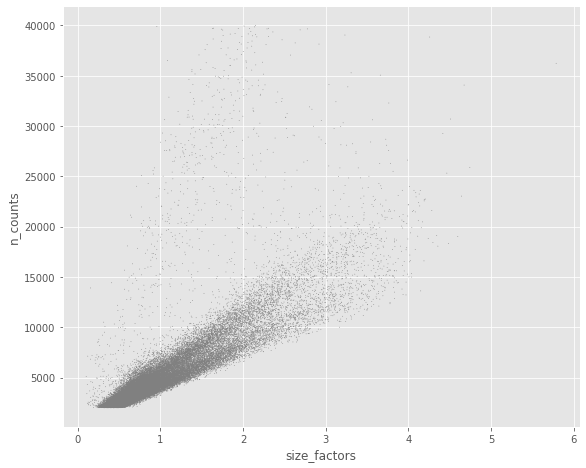

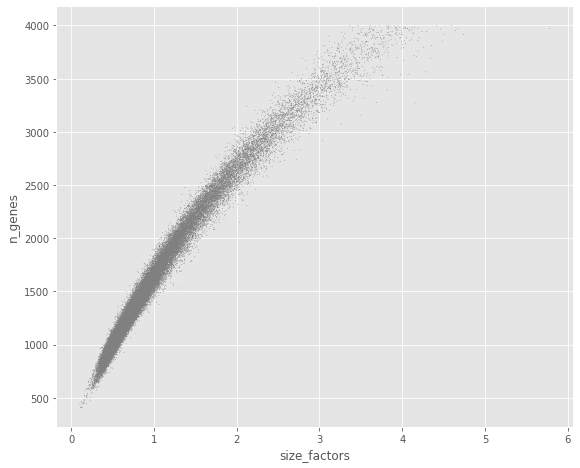

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


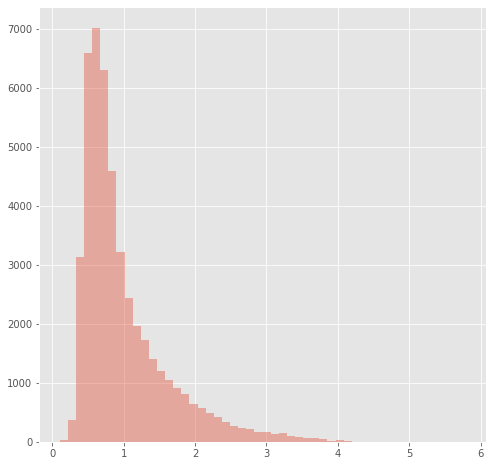

In [154]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [ ]:
# Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [155]:
#Normalize adata 
adata.X = adata.X.multiply(sp.sparse.csr_matrix(1/adata.obs['size_factors'].values[:,None]))
sc.pp.log1p(adata)

In [156]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 2.3 Highly Variable Genes
Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these. <br/>
Highly variable gene information is stored automatically in the adata.var['highly_variable'] field.

Note: raw code of scanpy may get error if the bin edges are duplicated. The error message is ** Bin edges must be unique, You can drop duplicate edges by setting the 'duplicates' kwarg**. To makesure the error would not occur for all cases, you can change the source code in line 244 of the file https://github.com/scverse/scanpy/blob/master/scanpy/preprocessing/_highly_variable_genes.py#L295-L564.  add a parameter duplicates='drop'

In [158]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=4000,n_bins=50)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


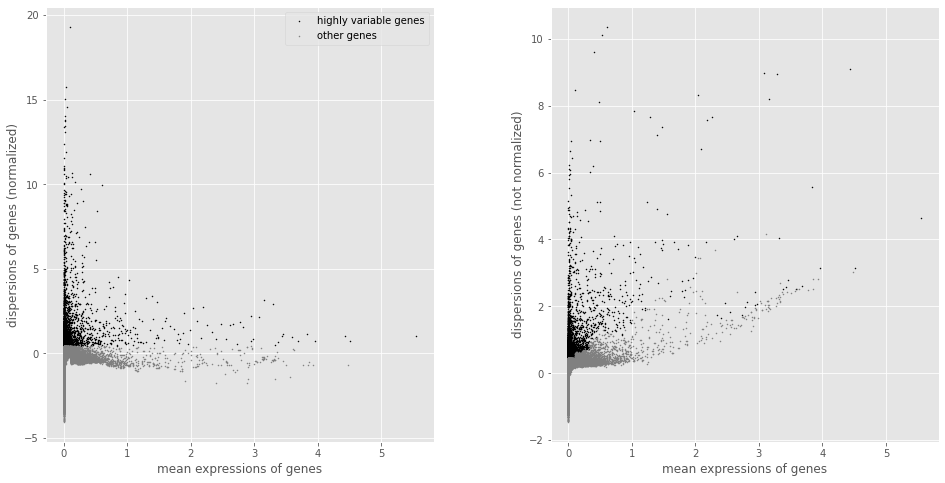

In [103]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

## 2.4 Batch correction
Origianl pipeline uses combat, usually correct based on sample. 
There are some other popular batch correction method like BBKNN tutorial or ingest here for integrating datasets.https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html. Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction. <br/>

Based on the benchmark of batch effect removal methods [here](https://www.nature.com/articles/s41592-021-01336-8). Scanorama was one of the top recommended algorithms. So we use scanorama in this pipeline.

computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:03)


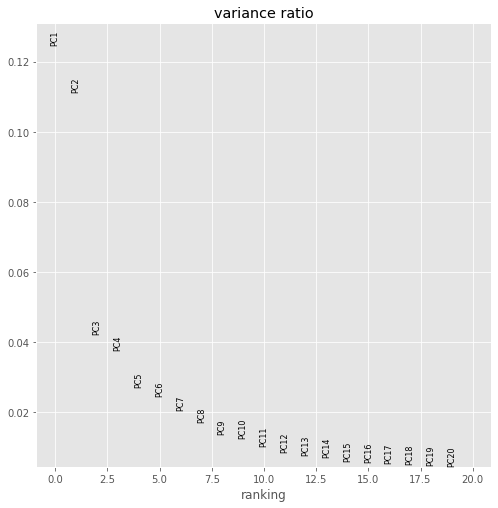

In [159]:
n_pc = 20
sc.tl.pca(adata, n_comps=n_pc, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, n_pcs=n_pc)

In [160]:
sce.pp.scanorama_integrate(adata, 'sample')
sce.pp.harmony_integrate(adata, 'sample', max_iter_harmony = 15)

[[0.         0.11128049 0.06569343 0.35222222 0.11972371 0.73369148
  0.06753645 0.00677638 0.19953952 0.02916347 0.80966999 0.24251727
  0.04604758 0.06523408 0.02532617 0.0437452  0.01688411 0.01611665
  0.24251727 0.00738916]
 [0.         0.         0.10948905 0.00914634 0.02286585 0.06554878
  0.80487805 0.44969512 0.06554878 0.14329268 0.03506098 0.1402439
  0.1722561  0.03353659 0.11280488 0.12042683 0.02286585 0.0929878
  0.09756098 0.0320122 ]
 [0.         0.         0.         0.00729927 0.6350365  0.03649635
  0.41605839 0.06569343 0.         0.01094891 0.01824818 0.17883212
  0.2189781  0.39781022 0.10218978 0.02189781 0.0729927  0.00364964
  0.         0.        ]
 [0.         0.         0.         0.         0.67666667 0.55777778
  0.06444444 0.00222222 0.24777778 0.05111111 0.76444444 0.09444444
  0.01555556 0.03555556 0.06777778 0.09555556 0.02666667 0.03111111
  0.27666667 0.01372273]
 [0.         0.         0.         0.         0.         0.24804857
  0.17259324 0.040

2022-11-08 08:22:03,315 - harmonypy - INFO - Iteration 1 of 15
Iteration 1 of 15
2022-11-08 08:22:15,692 - harmonypy - INFO - Iteration 2 of 15
Iteration 2 of 15
2022-11-08 08:22:27,976 - harmonypy - INFO - Iteration 3 of 15
Iteration 3 of 15
2022-11-08 08:22:40,222 - harmonypy - INFO - Iteration 4 of 15
Iteration 4 of 15
2022-11-08 08:22:53,946 - harmonypy - INFO - Iteration 5 of 15
Iteration 5 of 15
2022-11-08 08:23:06,537 - harmonypy - INFO - Iteration 6 of 15
Iteration 6 of 15
2022-11-08 08:23:13,310 - harmonypy - INFO - Iteration 7 of 15
Iteration 7 of 15
2022-11-08 08:23:25,395 - harmonypy - INFO - Iteration 8 of 15
Iteration 8 of 15
2022-11-08 08:23:29,627 - harmonypy - INFO - Iteration 9 of 15
Iteration 9 of 15
2022-11-08 08:23:41,700 - harmonypy - INFO - Iteration 10 of 15
Iteration 10 of 15
2022-11-08 08:23:54,360 - harmonypy - INFO - Iteration 11 of 15
Iteration 11 of 15
2022-11-08 08:24:10,285 - harmonypy - INFO - Converged after 11 iterations
Converged after 11 iterations


## 2.5 UMAP visualize to choose batch effect methods
This step aims to test which batch effect removal method works better. Currently we applied two methods: scanorama and harmony.

computing neighbors
    finished: added to `.uns['scanorama']`
    `.obsp['scanorama_distances']`, distances for each pair of neighbors
    `.obsp['scanorama_connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


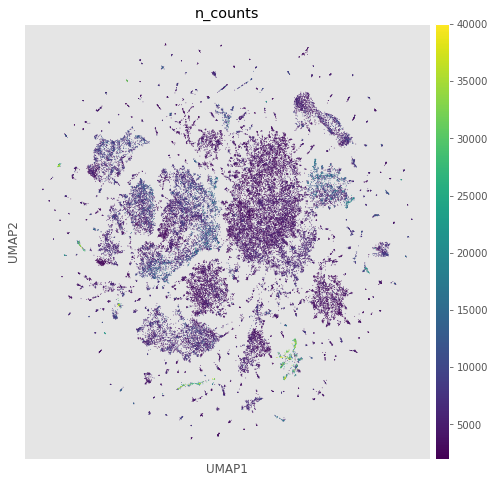

In [106]:
# Calculate the UMAP using scanorama
sc.pp.neighbors(adata, use_rep = 'X_scanorama', key_added='scanorama')
sc.tl.umap(adata, neighbors_key='scanorama')
sc.pl.umap(adata, color='n_counts')

computing neighbors
    finished: added to `.uns['hmny']`
    `.obsp['hmny_distances']`, distances for each pair of neighbors
    `.obsp['hmny_connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


... storing 'phase' as categorical


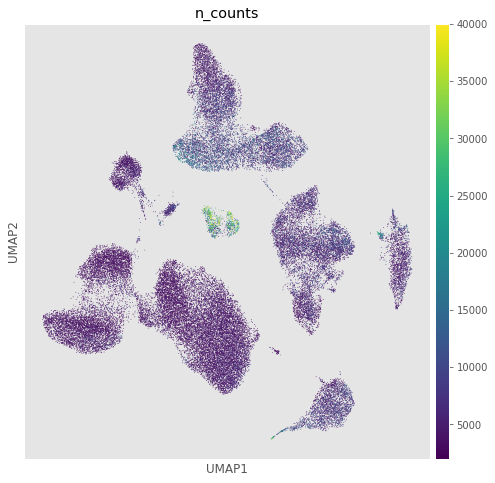

In [162]:
# Calculate the UMAP using harmany
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony',key_added='hmny')
sc.tl.umap(adata, neighbors_key='hmny')
sc.pl.umap(adata, color='n_counts')

Based on this datasets, scanorama has many cells scattered around the main clusters, while harmany has more clean clusters. So in this case harmony performs better. But in other datasets the results may change.

The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.X
- batch corrected data in adata.obsm['X_scanorama'] or adata.obsm['']
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

## 2.6 Cell cycle scoring
Annotate cell state in cell cycle. States are S, G2.M, 

In [161]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_ens = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes)]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_ens, g2m_genes=g2m_genes_ens)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    1395 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    1500 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


# 3. Downstream analysis
## 3.1 Clustering
First calculate PCA, then use the PCA to get K nearest neighbor, these two steps were done before. Here we use leiden method to do clustering.
You can set random_state to make sure the results is reproducible.

In [39]:
sc.tl.leiden(adata, key_added='leiden_r0.5', resolution=0.5, neighbors_key='hmny')
sc.tl.leiden(adata, key_added='leiden_r1', resolution=1.0, neighbors_key='hmny')

running Leiden clustering
    finished: found 14 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:00:05)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden_r1', the cluster labels (adata.obs, categorical) (0:00:06)


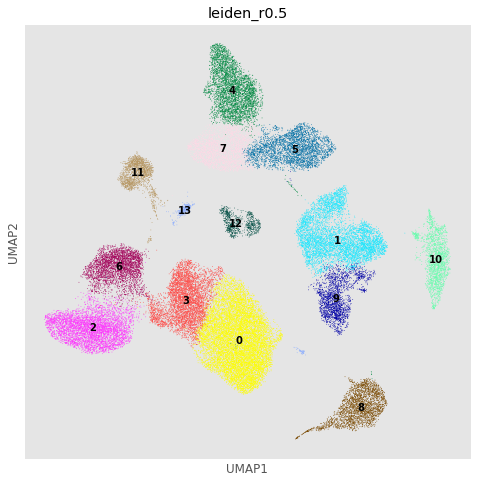

In [40]:
sc.pl.umap(adata, color=['leiden_r0.5'], palette=sc.pl.palettes.default_102, legend_loc='on data')

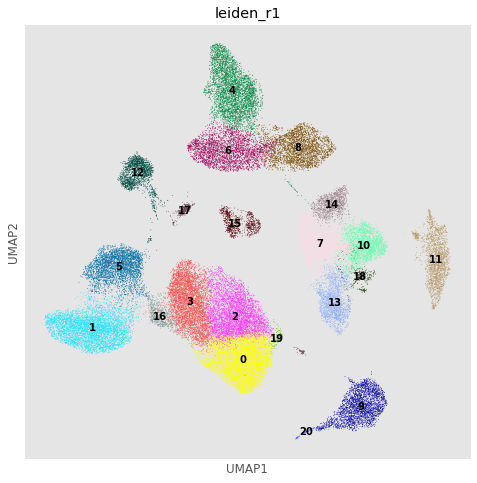

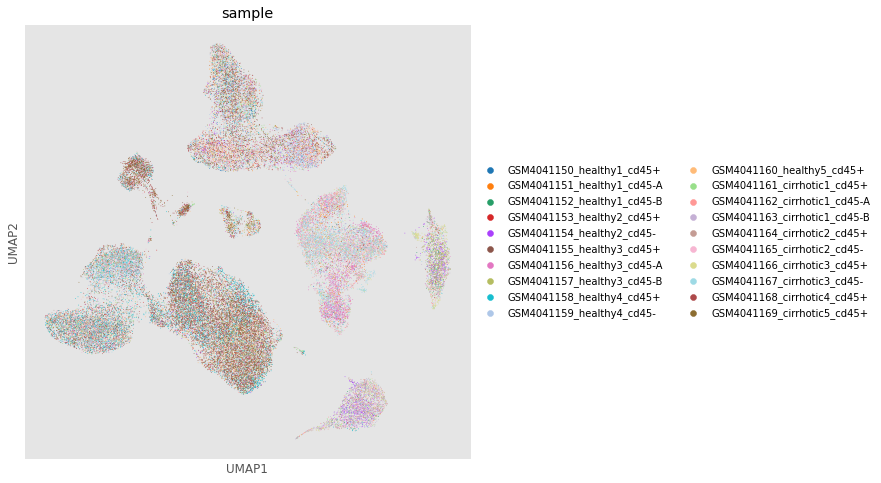

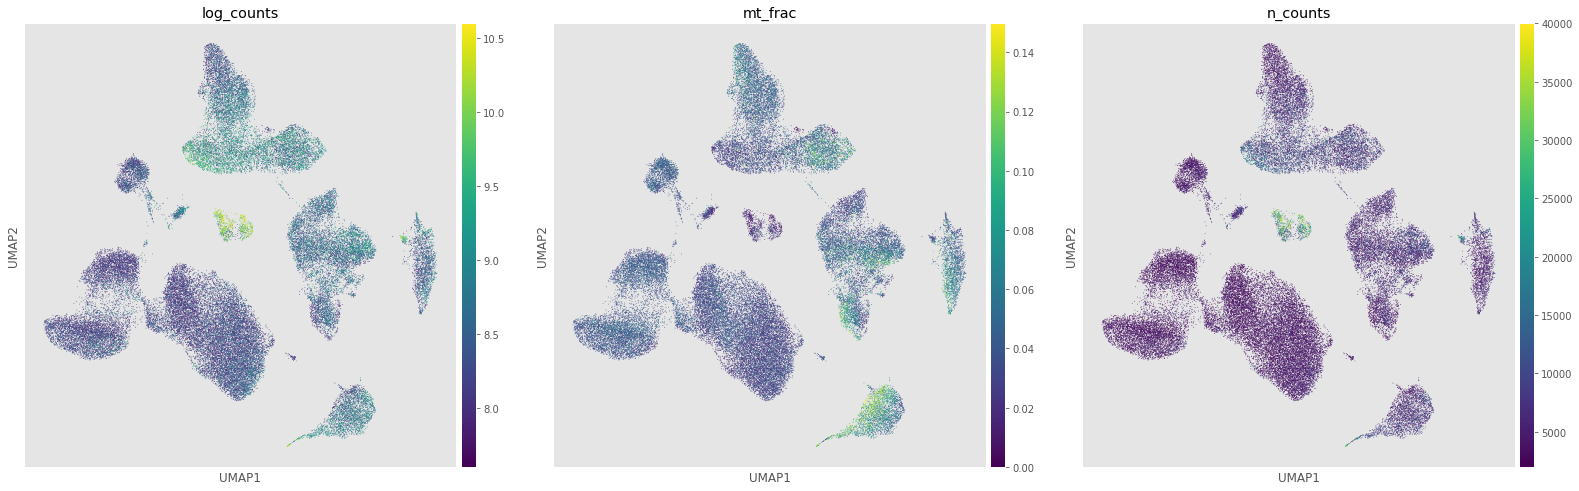

In [204]:
# Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['leiden_r1'], palette=sc.pl.palettes.default_102, legend_loc='on data')
sc.pl.umap(adata, color=['sample'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac', 'n_counts'])

## 3.2 Marker genes & cluster annotation
This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

In [ ]:
# Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')
sc.tl.rank_genes_groups(adata, groupby='leiden_r1', key_added='rank_genes_r1')

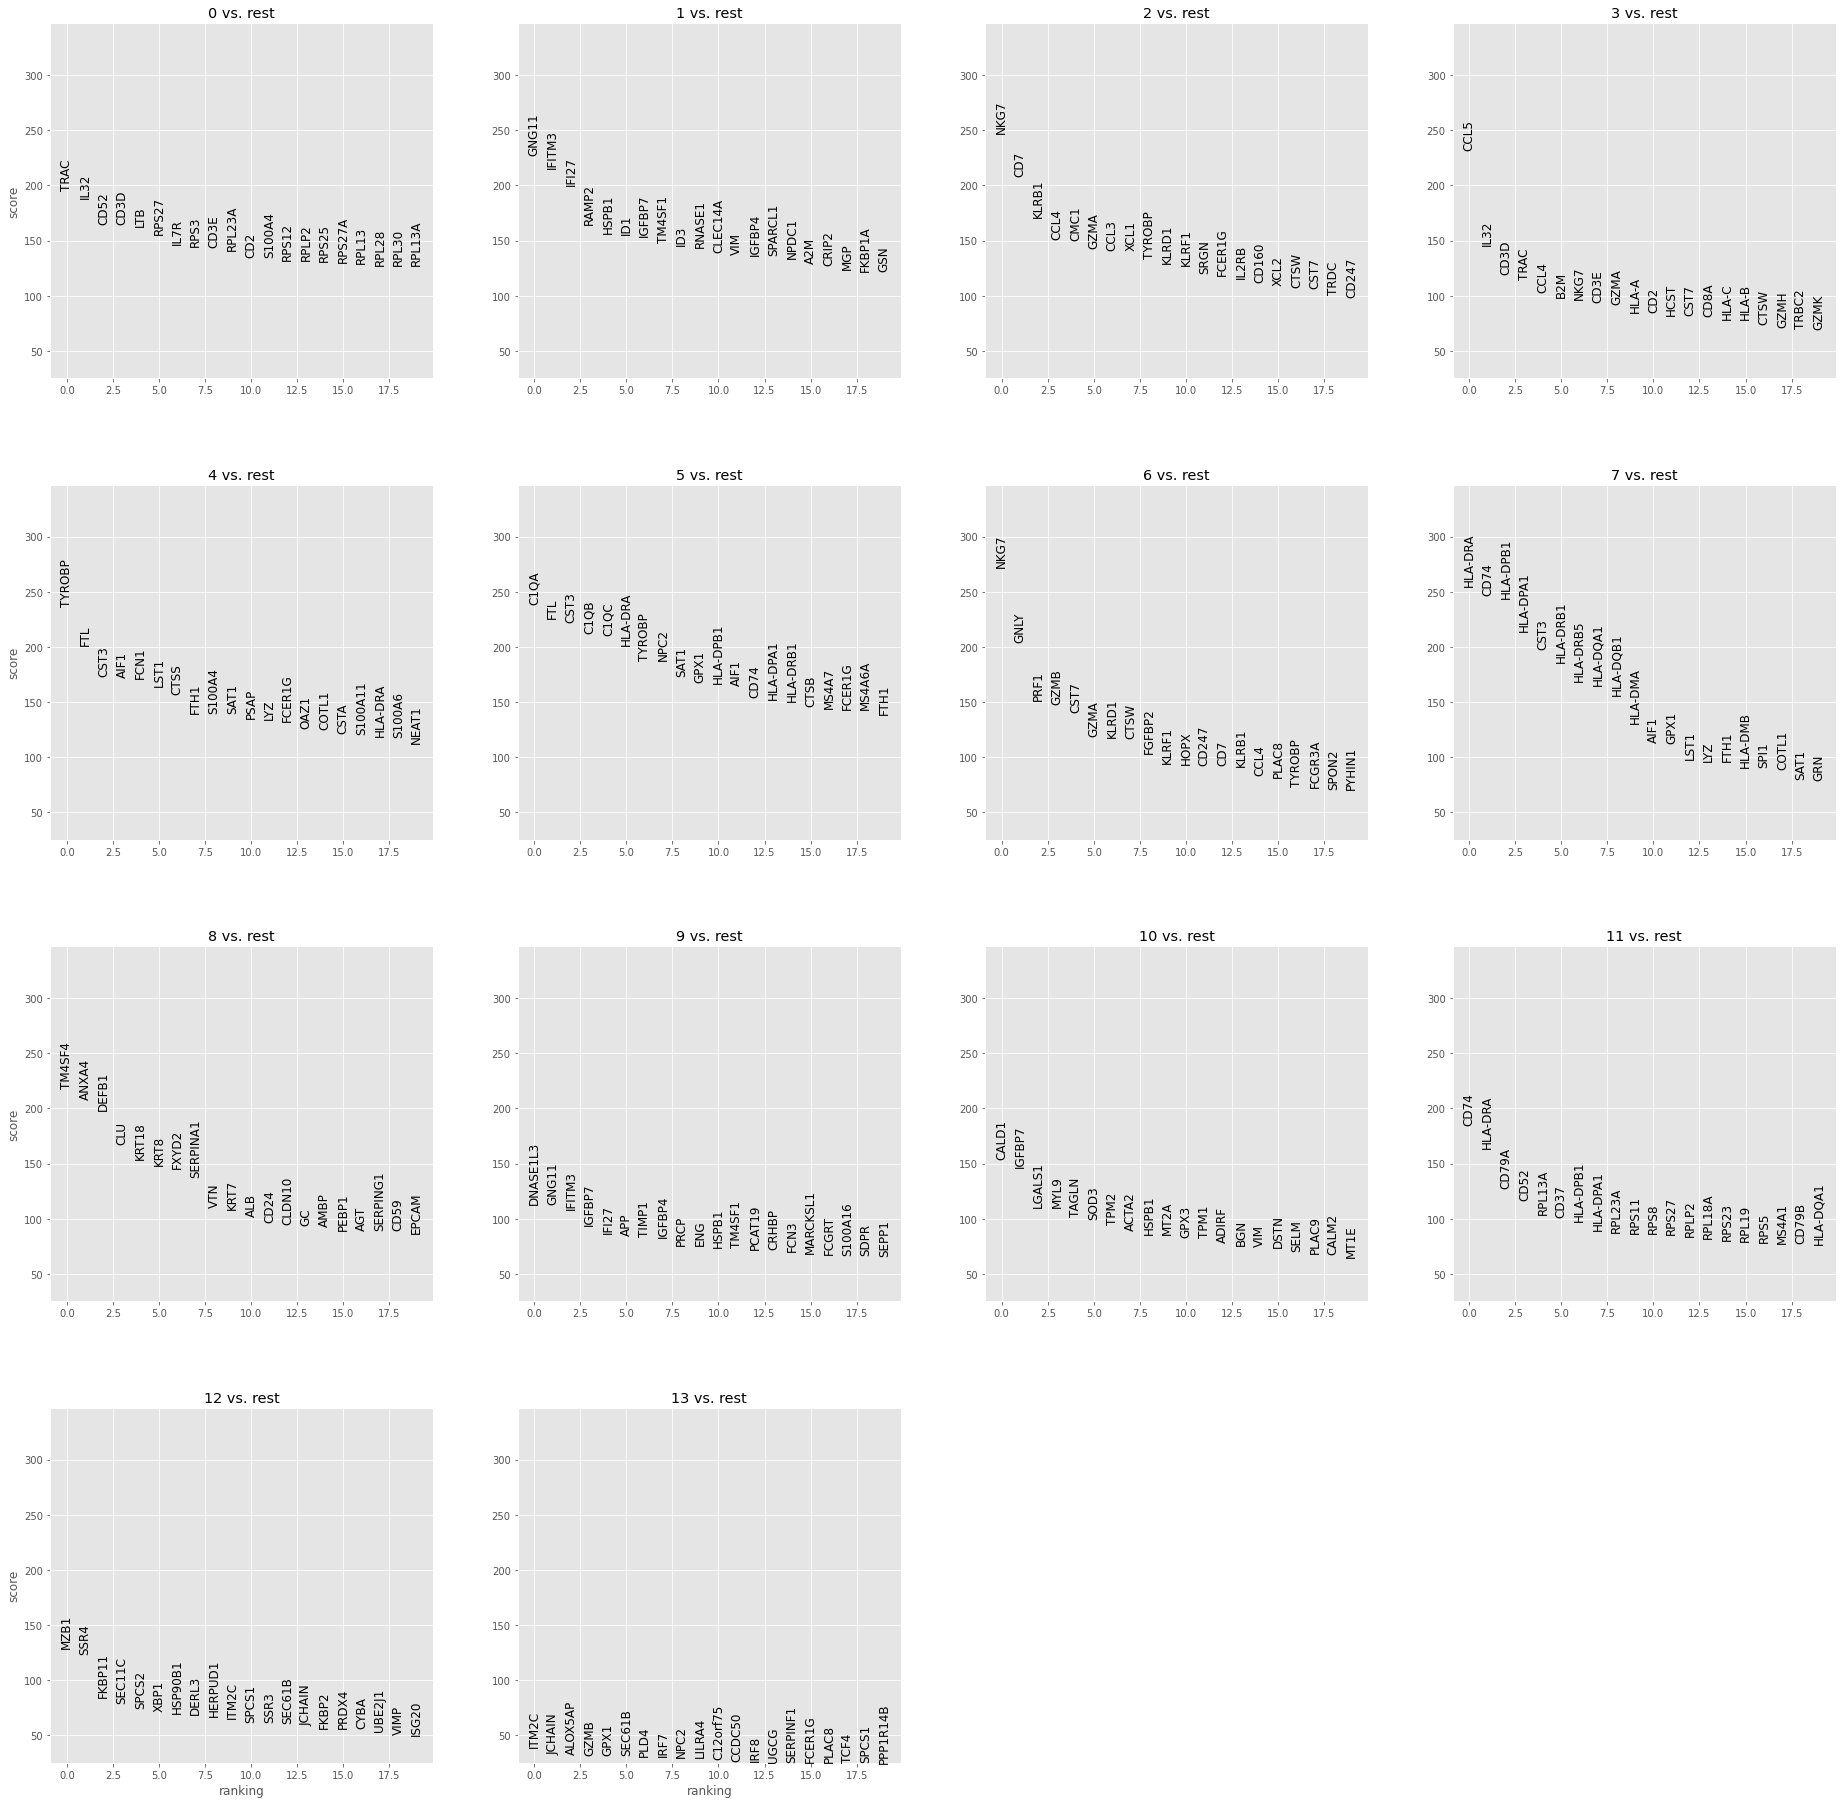

In [44]:
#Plot marker genes, need to change groups based on how many clusters you get
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)

### 3.2.1 Annotate using SCSA
Tools is available here https://github.com/bioinfo-ibms-pumc/SCSA. The SCSA results for cell type annotation mainly has two categories. 'Good' indicates the prediction is of high quality. '?' means it's not quite certain about the cell types and it listed two top predictions. We recommend to run SCSA first using the specific tissue of your sample, then run with all tissues and cross check the two predictions. Finally do manual curation of gene list to determine the cell type.

In [45]:
# 1. format files
result = adata.uns['rank_genes_r0.5']
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
cluster_fn = f'{work_dir}/scanpy_cluster.txt'
dat.to_csv(cluster_fn)

In [46]:
# need to change some parameters
species = 'Human'
tissue = 'Liver'
scsa_anno_fn = f'{work_dir}/scanpy_scsa_anno.txt'
cell_anno_db_fn = '/opt/SCSA/whole.db'
cmd = f'python /opt/SCSA/SCSA.py -d {cell_anno_db_fn} -i {cluster_fn} -s scanpy -E -f1.5 \
       -p 0.01 -o {scsa_anno_fn} -m txt -b -g {species} -k {tissue}'
log = os.popen(cmd).read()
print(log)

Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
Namespace(Gensymbol=True, MarkerDB=None, celltype='normal', cluster='all', db='/opt/SCSA/whole.db', foldchange=1.5, input='/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/r01_ref_scrna/liver_cirrohtic//scanpy_cluster.txt', list_tissue=False, noprint=True, norefdb=False, outfmt='txt', output='/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/r01_ref_scrna/liver_cirrohtic//scanpy_scsa_anno.txt', pvalue=0.01, source='scanpy', species='Human', target='cellmarker', tissue='Liver', weight=100.0)
Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
load markers: 918
Cluster 0 Gene number: 398
Other Gene number: 412
Cluster 1 Gene number: 2247
Other Gene number: 411
Cluster 10 Gene number: 2232
Other Gene number: 404
Cluster 11 Gene number: 466
Other Gene number: 420
Cluster 12 Gene number: 1180
Other Gene number: 417
Cluster 13 Gene number: 637
Other Gene number: 420
Cluster 2 Gene number: 415
O

/opt/python/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 3.2.2 Manual curation of the initial annotation
This step requires users to check the details of the inital cell type annotation and then refine the annotation.

In [47]:
n_clust = adata.obs['leiden_r0.5'].unique().shape[0]
init_ct = log.split('\n')[-(n_clust+1):-1]
init_celltype = {}
for c in init_ct:
    c = c.replace('\'','')
    c = c[1:-1].split(',')
    init_celltype[c[0]] = c[2][1:]

In [49]:
# manual curation of the predicted cell types
init_celltype['1'] = 'Endo'
init_celltype['2'] = 'ILC'
init_celltype['4'] = 'MP'
init_celltype['5'] = 'MP'
init_celltype['6'] = 'ILC'
init_celltype['7'] = 'MP'
init_celltype['8'] = 'Hepatocyte'
init_celltype['9'] = 'Endo'
init_celltype['10'] = 'Mes'
init_celltype['12'] = 'Plasma'
init_celltype['13'] = 'pDC'
adata.obs['leiden_r0.5_celltype'] = adata.obs['leiden_r0.5'].map(lambda x: init_celltype[x] if x in init_celltype else x)
adata.obs['leiden_r0.5_celltype'] = adata.obs['leiden_r0.5_celltype'].astype('category')

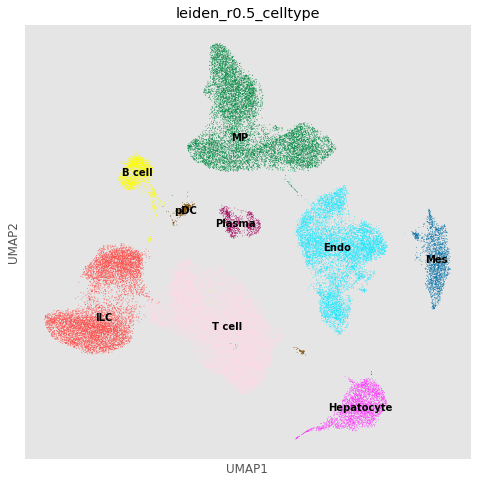

In [50]:
sc.pl.umap(adata, color=['leiden_r0.5_celltype'], palette=sc.pl.palettes.default_102, legend_loc='on data')

In [51]:
adata.obs['leiden_r0.5_celltype'].value_counts()

T cell        14811
MP             9418
ILC            7835
Endo           7743
Hepatocyte     2438
Mes            1841
B cell         1719
Plasma          777
pDC             371
Name: leiden_r0.5_celltype, dtype: int64

### 3.2.3 Sub clustering
Sometimes, some celltypes maybe a broad cell type and have subclusters, in this case, you can extract that cluster and do clustering for that cluster with higher resolution and annotate the cell types using SCSA.
Here we'll subcluster T cells

In [52]:
sc.tl.leiden(adata, restrict_to=('leiden_r0.5_celltype', ['T cell']), resolution=0.3, key_added='leiden_r0.5_tcell', neighbors_key='hmny')
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5_tcell', key_added='rank_genes_r0.5_tcell')

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_r0.5_tcell', the cluster labels (adata.obs, categorical) (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_r0.5_tcell']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


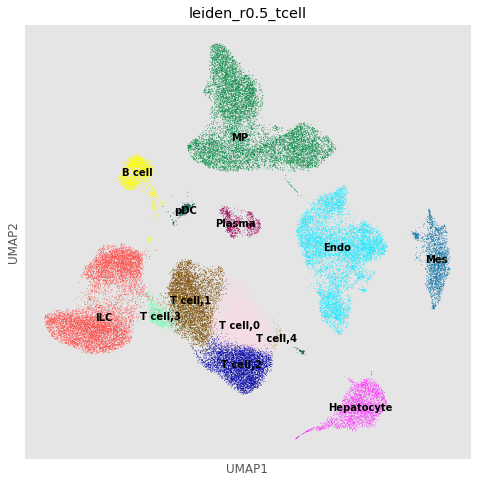

In [56]:
sc.pl.umap(adata, color=['leiden_r0.5_tcell'], palette=sc.pl.palettes.default_102, legend_loc='on data')

In [53]:
adata.obs['leiden_r0.5_tcell'].value_counts()

MP            9418
ILC           7835
Endo          7743
T cell,0      5199
T cell,1      4695
T cell,2      4153
Hepatocyte    2438
Mes           1841
B cell        1719
Plasma         777
T cell,3       642
pDC            371
T cell,4       122
Name: leiden_r0.5_tcell, dtype: int64

### 3.2.4  Annotate subclustering
Follows the same steps as annotation, this step may need more manual curation and it's better to ask experts to make sure you are annotating correctly.

In [54]:
# 1. format files
result = adata.uns['rank_genes_r0.5_tcell']
groups = result['names'].dtype.names
dat = pd.DataFrame({group.replace('_','-') + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
cluster_fn = f'{work_dir}/scanpy_cluster_tsub.txt'
dat.to_csv(cluster_fn)

In [55]:
# need to change some parameters
species = 'Human'
tissue = 'Blood'
scsa_anno_fn = f'{work_dir}/scanpy_scsa_anno_tsub.txt'
cell_anno_db_fn = '/opt/SCSA/whole.db'
cmd = f'python /opt/SCSA/SCSA.py -d {cell_anno_db_fn} -i {cluster_fn} -s scanpy -E -f1.5 \
       -p 0.01 -o {scsa_anno_fn} -m txt -b -g {species} -k {tissue}'
log = os.popen(cmd).read()
print(log)

Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
Namespace(Gensymbol=True, MarkerDB=None, celltype='normal', cluster='all', db='/opt/SCSA/whole.db', foldchange=1.5, input='/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/r01_ref_scrna/liver_cirrohtic//scanpy_cluster_tsub.txt', list_tissue=False, noprint=True, norefdb=False, outfmt='txt', output='/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf/r01_ref_scrna/liver_cirrohtic//scanpy_scsa_anno_tsub.txt', pvalue=0.01, source='scanpy', species='Human', target='cellmarker', tissue='Blood', weight=100.0)
Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
load markers: 1449
Cluster B cell Gene number: 466
Other Gene number: 731
Cluster Endo Gene number: 2770
Other Gene number: 677
Cluster Hepatocyte Gene number: 3093
Other Gene number: 714
Cluster ILC Gene number: 503
Other Gene number: 719
Cluster MP Gene number: 1693
Other Gene number: 531
Cluster Mes Gene number: 2232
Other Gene number: 72

/opt/python/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [57]:
tsub_cell = {'T cell,0':'TNK', 'T cell,1':'CD8+_T', 'T cell,2':'Treg', 'T cell,3':'TNK', 'T cell,4':'NKT'}

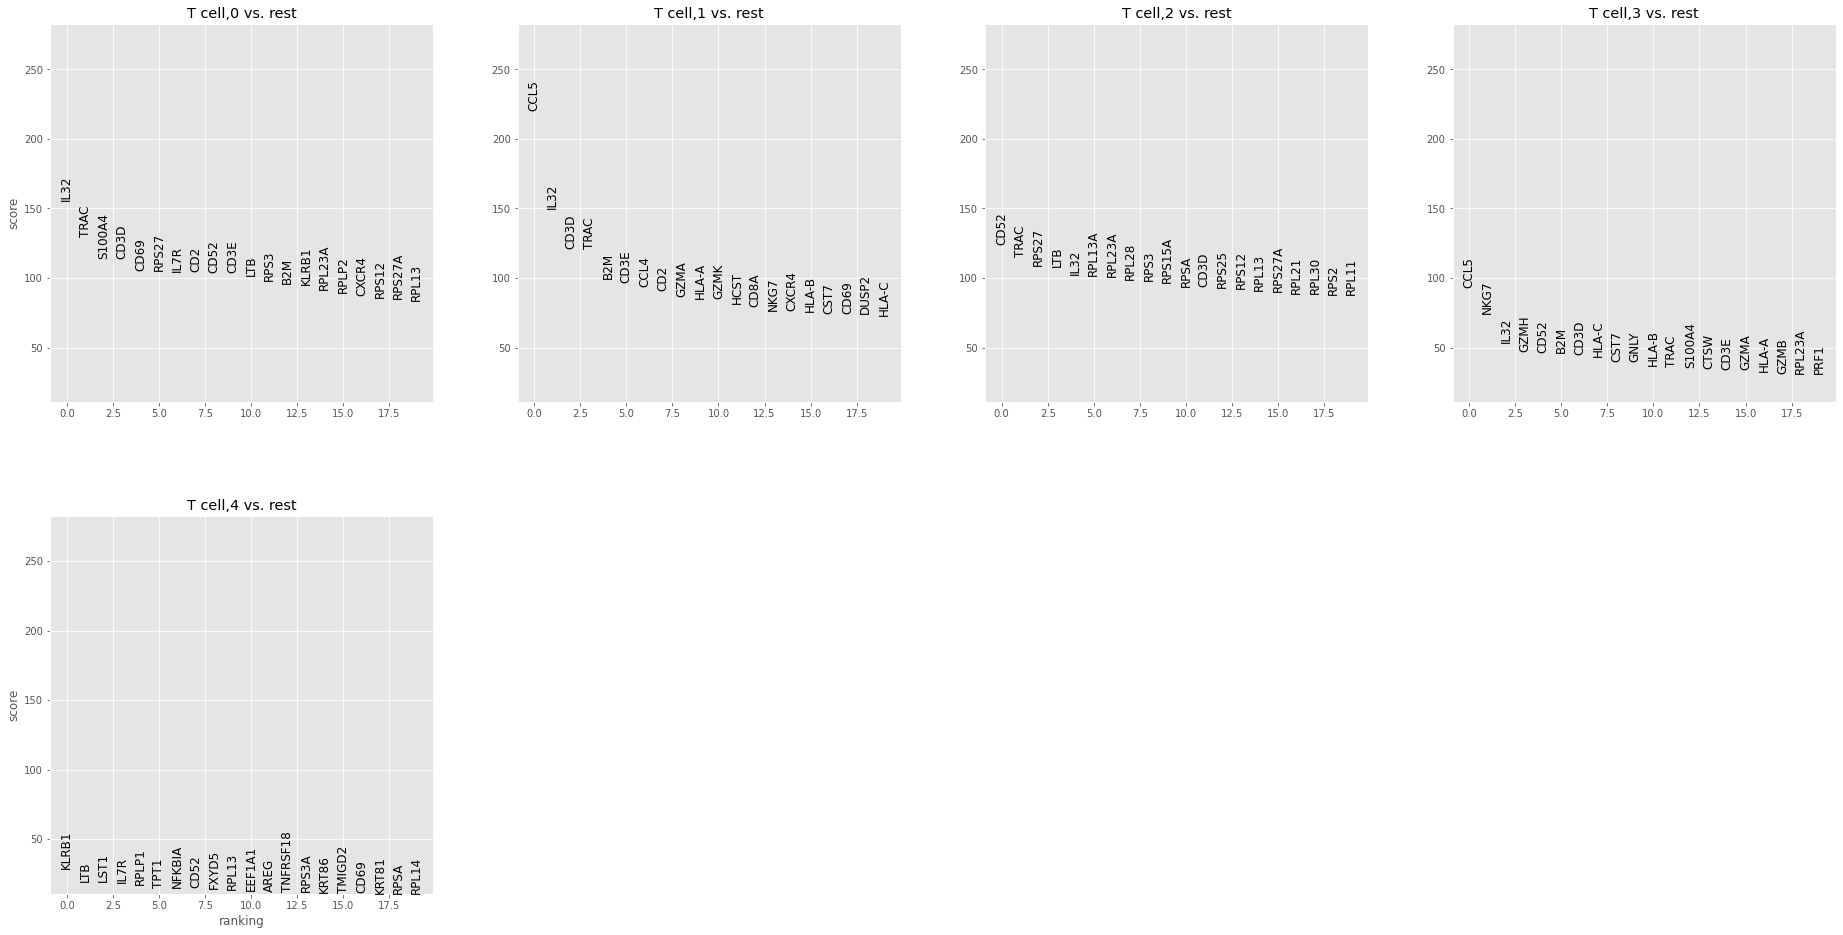

In [58]:
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5_tcell', groups=['T cell,0','T cell,1','T cell,2','T cell,3','T cell,4'], fontsize=12)

In [59]:
# add final annotation
adata.obs['final_celltype'] = adata.obs['leiden_r0.5_tcell'].map(lambda x: tsub_cell[x] if x in tsub_cell else x)
adata.obs['final_celltype'].value_counts()

MP            9418
ILC           7835
Endo          7743
TNK           5841
CD8+_T        4695
Treg          4153
Hepatocyte    2438
Mes           1841
B cell        1719
Plasma         777
pDC            371
NKT            122
Name: final_celltype, dtype: int64

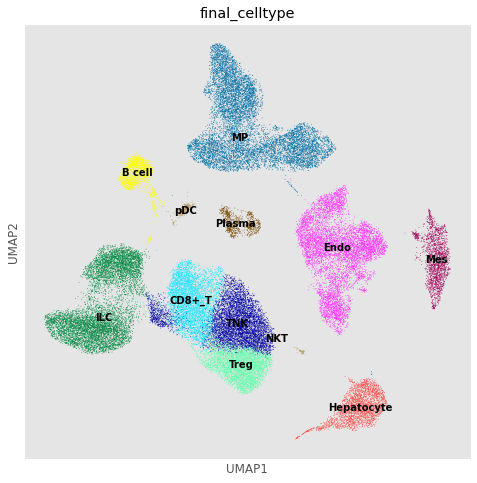

In [64]:
sc.pl.umap(adata, color=['final_celltype'], palette=sc.pl.palettes.default_102, legend_loc='on data')

In [63]:
anno_h5_fn = f'{work_dir}/liver_anno_ct.h5ad'
adata.write(anno_h5_fn)

## 3.3. Trajectory and Peudotime analysis
In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.